# Assignment 4
### Do three of six.

### Exercise 1: Contingent Comparisons
- Load the Minnesota use of force data.
- Bootstrap the proportion of missing values for `subject_injury` for each race, and plot the results with grouped KDE and ECDF plots
- Describe what you see. When we consider second order uncertainty, how similar or different are the sampling distributions of these proportions? 

In [1]:
import pandas as pd
df = pd.read_csv('c:/Users/speed/DS-5030/data/mn_police_use_of_force.csv')
df.head()

,response_datetime,problem,is_911_call,primary_offense,subject_injury,force_type,force_type_action,race,sex,age,type_resistance,precinct,neighborhood
0,2016/01/01 00:47:36,Assault in Progress,Yes,DASLT1,NaN,Bodily Force,Body Weight to Pin,Black,Male,20.0,Tensed,1,Downtown East
1,2016/01/01 02:19:34,Fight,No,DISCON,NaN,Chemical Irritant,Personal Mace,Black,Female,27.0,Verbal Non-Compliance,1,Downtown West
2,2016/01/01 02:19:34,Fight,No,DISCON,NaN,Chemical Irritant,Personal Mace,White,Female,23.0,Verbal Non-Compliance,1,Downtown West
3,2016/01/01 02:28:48,Fight,No,PRIORI,NaN,Chemical Irritant,Crowd Control Mace,Black,Male,20.0,Commission of Crime,1,Downtown West
4,2016/01/01 02:28:48,Fight,No,PRIORI,NaN,Chemical Irritant,Crowd Control Mace,Black,Male,20.0,Commission of Crime,1,Downtown West


In [2]:
# Bootstrap the proportion of missing values for `subject_injury` for each race
def bs_na_prop(df: pd.DataFrame, var: str):
    props = df.isna().value_counts(normalize=True)
    return props[True]


In [30]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

def simulate(df, var, fcn, axes, S=1000, plot=True):
    x = df[var]
    race = df['race'].unique()[0]

    estimates = [fcn(x.sample(frac=1.0,replace=True), var) for s in range (S)]

    if plot:
        sns.kdeplot(estimates, ax = axes[0], label=race).set(title='KDE of Computed Statistics')
        sns.ecdfplot(estimates, ax = axes[1], label=race).set(title='ECDF of Computed Statistics')

    return estimates

C:\Users\speed\AppData\Local\Temp\ipykernel_22884\2708208197.py:12: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(estimates, ax = axes[0], label=race).set(title='KDE of Computed Statistics')


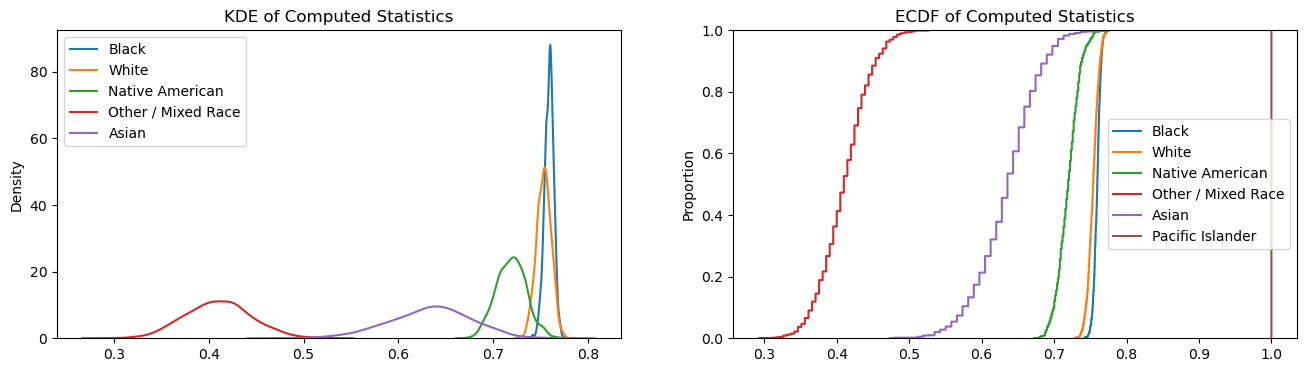

In [31]:
races =  df['race'].dropna().unique()
fig, axes = plt.subplots(1, 2, figsize=(16, 4))
for race in races:
    simulate(df[df['race'] == race], 'subject_injury', bs_na_prop, axes)
axes[0].legend()
axes[1].legend()
plt.show()

In [33]:
df['race'].value_counts()

race
Black                 7648
White                 3129
Native American        784
Other / Mixed Race     205
Asian                  129
Pacific Islander         6
Name: count, dtype: int64

In the KDE, we notice that Other/Mixed race has the lowest rate of missing observations for 'subject_injury', with little overlap from the sampling distribution with the others on the plot. Asian is next lowest, with slight overlap with Native American. White and black have significant overlap and both have distinctly higher mean missing observations and densities. From the KDE, since we observe that the plot of Other/Mixed does not have overlap, that grouping likely has the lowest proportion of missing values compared to the other race groupings. On the other hand, we cannot conclusively determine which has the higher proportion between White and Black due to the significant overlap in the KDE plots. Additionally, Pacific Islander was dropped from the plot because of the 6 observations, all were missing the 'subject_injury" value. While this is a 1.00 proportion of missing values, with such little sample size, no conclusions should be made.

These conclusions are backed up by the ECDF. As there are significantly more observations of Black and White people in the data, there is less variance in the sample distributions, which is why the KDEs for those race groupings are tighter with higher peaks and their ECDFs are steeper.

### Exercise 2: Invitation to Inference
- Run the simulation code line by line and comment what each line is doing, or write your own code to do the resampling
- Open the NHANES or Ames prices or College Completion data
- Use the above function `simulate` to get a sample of estimates for your statistic and your data
- Create a new function, `interval(L,H,estimates)`, that computes the $L$-th and $H$-th quantiles for your estimates, $H>L$
- If $L=.05$ and $H=.95$, this is a **90-percent confidence interval**: "For our statistic, this interval captures the true value of the population parameter 90 percent of the time. (We are 90% **confident** that it includes the true value of the parameter, but the probability that the true parameter lies in this interval is 0 or 1.)"
- We will spend much more time on this later in class, but for people who have done hypothesis testing before, you now know how to do it directly from the data: No central limit theorem required.

### Exercise 3: Intro to A/B Testing
- Go here, and read about this study: https://www.clinicaltrials.gov/study/NCT01985360
- Read the Study Overview and explain what the goal of the trial is 
- Read the Study Plan and explain how it was designed and why -- there's lots of medical jargon, but the main point is how patients were assigned to interventions. 
- Read the Results Posted: Go to **Outcome Measures**. Explain how table 1 ("Incidence of Death from Any Cause or Myocardial Infarction") is a contingency table. These are the data for this exercise.
- What is the difference in surival rates between the invasive strategy and the conservative strategy?
- Bootstrap the survival rates for the two groups, and plot them as KDEs and ECDFs against one another
- Bootstrap the difference in surival rates, and plot it as a KDE and ECDF
- Is this an effective health intervention? Explain your answer clearly

This would be what CS people call **A/B testing** and everyone else called a **randomized controlled trial**: Using randomized assignment to detect the difference in outcomes between two groups. (We've just done a non-parametric version of a two-sample t-test.)

### Exercise 4: Prediction Uncertainty
- Pick a dataset and two continuous variables.
- Recall the LCLS estimator:
$$
\hat{y}(z) =  \frac{ \frac{1}{N} \sum_{i=1}^N y_i \times \frac{1}{h}k\left( \frac{z - x_i}{h} \right)}{ \frac{1}{N} \sum_{i=1}^N \frac{1}{h} k\left( \frac{z - x_i}{h} \right)}
$$
with the Epanechnikov kernel and the standard plug-in bandwidth for $h$
- Compute and plot this line for 30 bootstrap samples. Notice where there is a lot of variation in the predictions, versus little variation in the predictions.
- Now, for any $z$, we can bootstrap a distribution of predictions using the above formula. Do this at the 25th percentile, median, and 75th percentile of $X$.
- Now, pick a grid for $z$: Obvious choices are all of the unique values in the data, or an equally spaced grid from the minimum value to the maximum value. For each $z$, bootstrap a sample of predictions and compute the .05 and .95 quantiles. Plot these error curves along with your LCLS estimate. Where are your predictions "tight"/reliable? Where are they highly variable/unreliable?

### Exercise 5
- Extend the `kde` class by adding a method to do bandwidth selection using a simple train-test split
- Extend the `kde` class by adding a method to do bandwidth seleciton by $k$-fold cross validation

### Exercise 6
In this exercise, you're going to do for LCLS what we just did for KDE: Pick the bandwidth 

Recall, the LCLS estimator is
$$
\hat{y}_{N,h}(z) = \dfrac{\frac{1}{N} \sum_{i=1}^N y_i \times \frac{1}{h}k\left(\frac{z-x_i}{h}\right)}{\frac{1}{N} \sum_{i=1}^N \frac{1}{h}k\left(\frac{z-x_i}{h} \right)}.
$$
- Select two numeric variables from a data set. Split the data into training and test sets.
- Write a `predict(X_{train},Y_{train},X_{train})` function/method that takes a set of values $X_{test}$ and data $(X_{train},Y_{train})$, and computed predicted values $\hat{y}(X_{test})$ 
- Write a function/method that selects the bandwidth by **minimizing** the **mean squared error** of the squared differences between $\hat{y}(x_j)$ and $y_j$ on the test set:
$$
MSE(h) = \frac{1}{N_{test}} \sum_{j=1}^{N_{test}} (y_j - \hat{y}_{N_{train},h}(x_j))^2
$$
Be sure you understand what's happening here: The training data are used to make predictions for each test observation $x_j$, and then the prediction $\hat{y}(x_j)$ and true value $y_j$ are compared using squared difference